## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the lead scoring dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).


In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not. 


In [28]:
!wget "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv" -O data.csv

--2025-10-23 02:45:29--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]  78.98K  --.-KB/s    in 0.007s  

2025-10-23 02:45:29 (11.4 MB/s) - ‘data.csv’ saved [80876/80876]



In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [30]:
df = pd.read_csv('data.csv')
df.shape

(1462, 9)

In [31]:
df.columns

Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score',
       'converted'],
      dtype='object')

### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`



In [32]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [33]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [34]:
categorical = df.select_dtypes(include=['object']).columns.tolist()
numerical = df.select_dtypes(include=['int64', 'float64']).columns.tolist() 
numerical.remove('converted')

In [35]:
categorical, numerical

(['lead_source', 'industry', 'employment_status', 'location'],
 ['number_of_courses_viewed',
  'annual_income',
  'interaction_count',
  'lead_score'])

In [36]:
df[numerical] = df[numerical].fillna(0.0)
df[categorical] = df[categorical].fillna('NA')

In [37]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [38]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`


In [39]:
for label in (numerical):
    score = roc_auc_score(df_train['converted'],df_train[label])
    if (score < 0.5):
        print ("recalculating for -", label)
        score = roc_auc_score(-df_train['converted'],df_train[label])
    print(f'{label}: {score:.3f}')

number_of_courses_viewed: 0.764
annual_income: 0.552
interaction_count: 0.738
lead_score: 0.614


Answer 1: number_of_courses_viewed has the highest AUC with 0.764

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [59]:
dv = DictVectorizer(sparse=False)

def train_model(df_train, dv):
    train_dicts = df_train[categorical + numerical].to_dict(orient='records')
    X_train = dv.fit_transform(train_dicts)
    y_train = df_train['converted'].values
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    return model

model = train_model(df_train, dv)

def predict_val(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    y = df['converted'].values
    y_pred = model.predict_proba(X)[:, 1]
    return y, y_pred

y_val, y_val_pred = predict_val(df_val, dv, model)

round(roc_auc_score(y_val, y_val_pred>=0.5) , 3)


    #print (y_val_pred[::10], y_val[::10])

0.648

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

In [50]:
def get_precision_recall(y, y_pred, t=0.5):
    actual_positive = (y == 1)
    actual_negative = (y == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print (f'Threshold: {t:.2f}  Precision: {precision:.3f}  Recall: {recall:.3f}, TP: {tp} FP: {fp} TN: {tn} FN: {fn}')
    return precision, recall


In [52]:
thresholds = np.linspace(0, 1, 100)
scores = []
for t in thresholds:
    precision, recall = get_precision_recall(y_val, y_val_pred, t)
    scores.append((t, precision, recall))

scores.count

Threshold: 0.00  Precision: 0.584  Recall: 1.000, TP: 171 FP: 122 TN: 0 FN: 0
Threshold: 0.01  Precision: 0.584  Recall: 1.000, TP: 171 FP: 122 TN: 0 FN: 0
Threshold: 0.02  Precision: 0.584  Recall: 1.000, TP: 171 FP: 122 TN: 0 FN: 0
Threshold: 0.03  Precision: 0.584  Recall: 1.000, TP: 171 FP: 122 TN: 0 FN: 0
Threshold: 0.04  Precision: 0.584  Recall: 1.000, TP: 171 FP: 122 TN: 0 FN: 0
Threshold: 0.05  Precision: 0.584  Recall: 1.000, TP: 171 FP: 122 TN: 0 FN: 0
Threshold: 0.06  Precision: 0.584  Recall: 1.000, TP: 171 FP: 122 TN: 0 FN: 0
Threshold: 0.07  Precision: 0.584  Recall: 1.000, TP: 171 FP: 122 TN: 0 FN: 0
Threshold: 0.08  Precision: 0.584  Recall: 1.000, TP: 171 FP: 122 TN: 0 FN: 0
Threshold: 0.09  Precision: 0.584  Recall: 1.000, TP: 171 FP: 122 TN: 0 FN: 0
Threshold: 0.10  Precision: 0.584  Recall: 1.000, TP: 171 FP: 122 TN: 0 FN: 0
Threshold: 0.11  Precision: 0.584  Recall: 1.000, TP: 171 FP: 122 TN: 0 FN: 0
Threshold: 0.12  Precision: 0.584  Recall: 1.000, TP: 171 FP: 12

/tmp/ipykernel_5844/3978718992.py:14: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


<function list.count(value, /)>

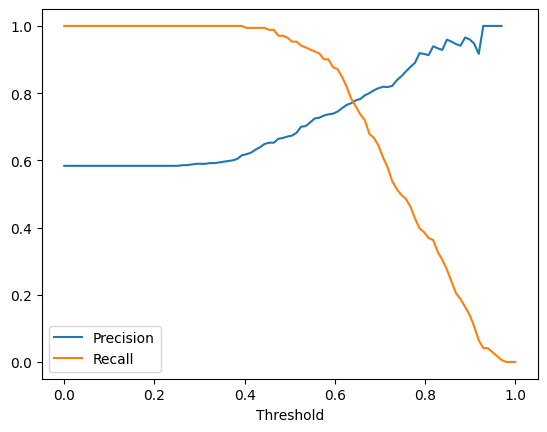

In [53]:
import matplotlib.pyplot as plt
plt.plot([x[0] for x in scores], [x[1] for x in scores], label='Precision')
plt.plot([x[0] for x in scores], [x[2] for x in scores], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.show()

Answer 3: Precision and Recall seem to intersect around t=0.65

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

In [54]:
f1scores = []
for score in scores:
    f1score = 2 * (score[1] * score[2]) / (score[1] + score[2])
    f1scores.append(f1score)


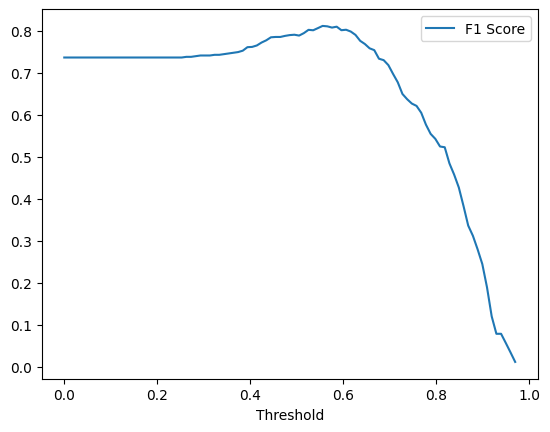

In [55]:
plt.plot([x[0] for x in scores], f1scores, label='F1 Score')
plt.xlabel('Threshold')
plt.legend()
plt.show()

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2025/homework/hw04
* If your answer doesn't match options exactly, select the closest one